In [1]:
from nilearn import plotting, image
import nibabel as nib
import os
import numpy as np
from pathlib import Path
import tarfile
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sub_list = os.listdir("HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2")
make_path = lambda x: "HCP_PTN1200/node_timeseries/3T_HCP1200_MSMAll_d100_ts2" + "/" + x

In [3]:
def data_uploader(file_path):
    return np.loadtxt(file_path)

In [4]:
paths_100 = [make_path(i) for i in sub_list]
sub_data = [np.loadtxt(path) for path in paths_100]

### One Subject

In [5]:
path = make_path(sub_list[0])
data = data_uploader(path)
X = np.array(data).astype(float)
X.shape #timepoints, brain regions

(4800, 100)

In [7]:
corr1 = np.corrcoef(X.T)
corr1.shape

(100, 100)

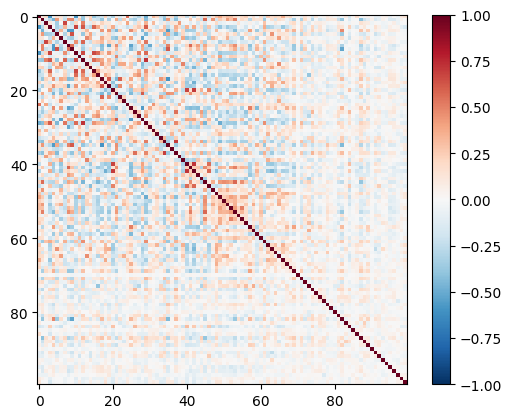

In [8]:
plt.imshow(corr1, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

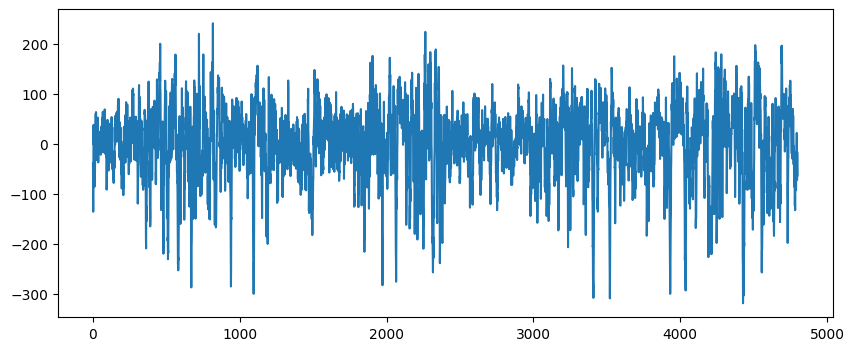

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[0])

In [10]:
np.std(X.T[0])

np.float64(74.47529661688012)

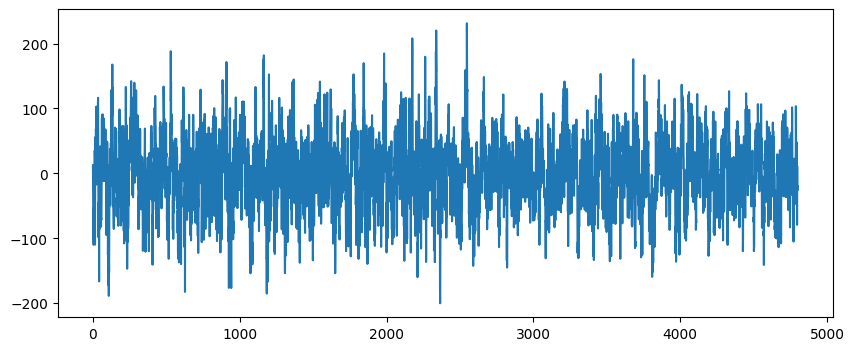

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(X.T[50])

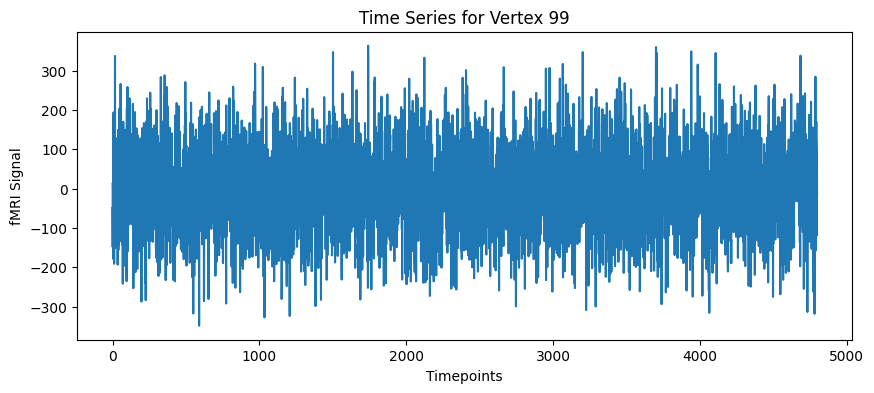

In [12]:
vertex_idx = 99
plt.figure(figsize=(10, 4))
plt.plot(X[0:, vertex_idx])
plt.title(f'Time Series for Vertex {vertex_idx}')
plt.xlabel('Timepoints')
plt.ylabel('fMRI Signal')
plt.show()

### Part 1: Try to average over multiple subjects

In [13]:
import nilearn.connectome as nc

In [14]:
sum(sub_data[1][:, 0])

np.float64(6.378021999998552)

In [15]:
sub_data[1].sum(axis=0)

array([ 6.378022  ,  0.48842   , -0.0140024 ,  1.903131  ,  0.798806  ,
        0.566513  ,  0.825554  ,  1.472018  , -5.518307  ,  0.5224174 ,
       -1.8758441 ,  1.3376301 , -0.466095  , -0.98502   , -4.282556  ,
       -1.886299  , -0.588089  ,  4.5858235 ,  1.34594208, -0.8541046 ,
        0.845162  , -1.00281   ,  0.1153546 , -1.0190523 ,  4.235223  ,
       10.9612159 , -0.6192982 ,  6.6068286 , -4.059312  , -0.406314  ,
        2.5386725 ,  1.43454   ,  3.13452   , -0.187211  , -1.092368  ,
       -1.228717  , -1.17849944, -3.284346  ,  2.517338  , -3.5654151 ,
        1.848404  , -2.624229  ,  1.516147  ,  0.765422  , -0.7892451 ,
        0.4831056 , -1.7621382 , -0.5358952 ,  0.530287  , -2.2177345 ,
       -3.873306  , -0.9315452 , -9.5900596 ,  0.249677  ,  1.12742   ,
       -0.9691555 , -0.2981493 ,  0.0155497 ,  1.0094118 ,  3.283138  ,
       -7.184701  ,  5.59637102,  3.562725  ,  1.4020335 ,  1.091671  ,
       -0.203821  , -2.6281391 , -1.356448  , -2.123287  ,  0.69

In [16]:
sub_data_var1 = np.array([sub/ sub.std(axis=0) for sub in sub_data]) #sub_data[1] / sub_data[1].std(axis=0)

In [17]:
cm = nc.GroupSparseCovariance()
cov_matrix = cm.fit(sub_data_var1)

In [18]:
#computes all covariances at once? Not sure how to combine these still
cm.covariances_

array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 1.01242151e-01, -1.99760857e-02,  1.11627898e-01, ...,
          5.90889808e-02,  1.84015029e-02,  5.63665416e-02],
        [ 1.57604159e-01,  3.50295186e-01, -1.41874018e-02, ...,
          2.53483283e-01,  4.48233212e-01,  3.27206058e-01],
        ...,
        [-4.73657757e-02, -1.32283817e-02,  3.20991936e-02, ...,
         -2.53417752e-02, -2.56820577e-02, -5.29404942e-02],
        [ 8.91898529e-02, -4.31605437e-02,  1.23740920e-01, ...,
          1.01818934e-01,  2.43338375e-03,  2.43409626e-02],
        [ 1.30696097e-01,  1.95684355e-02,  3.19914873e-02, ...,
          6.84873873e-02, -3.67253444e-02,  3.12695641e-02]],

       [[ 1.01242151e-01, -1.99760857e-02,  1.11627898e-01, ...,
          5.90889808e-02,  1.84015029e-02,  5.63665416e-02],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
          1.00000000e+00,  1.00000000e

In [19]:
#average each region signal across all subjects
X = sub_data_var1.mean(axis=0)
corr = np.corrcoef(X.T)

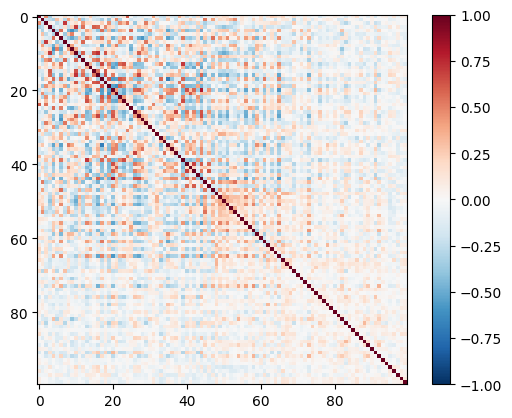

In [20]:
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

### Averaging the covariance matrices

In [21]:
arr = cm.covariances_
arr.shape

(100, 100, 1003)

In [22]:
#averaging covariance matrices
combined_covariance = np.mean(cm.covariances_, axis=2)

In [23]:
combined_covariance.shape

(100, 100)

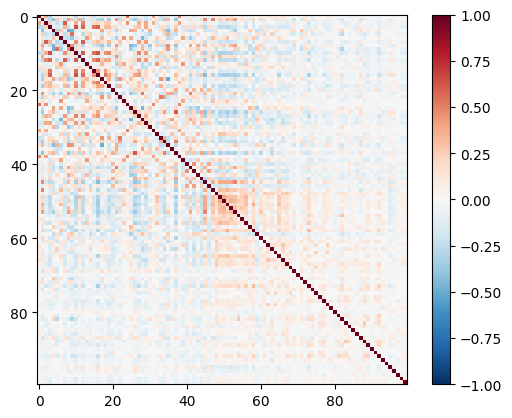

In [24]:
plt.imshow(combined_covariance, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()

In [25]:
#Hierarchial Bayesian Model???

### Part 2: Try to map brain connectivity

atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


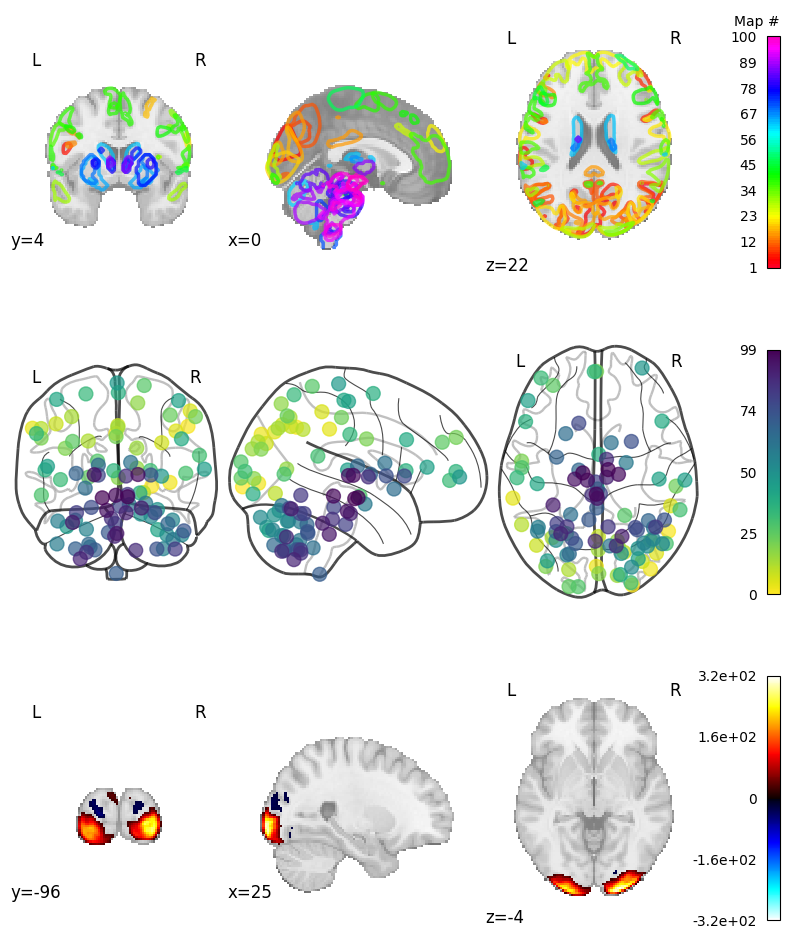

In [26]:
atlas = image.load_img("HCP_PTN1200/groupICA/groupICA_3T_HCP1200_MSMAll_d100.ica/melodic_IC_sum.nii.gz")
atlas = image.threshold_img(atlas, "99.5%") 
print("atlas has shape", ["x", "y", "z", "region"], "=", atlas.shape)

fig, axs = plt.subplots(nrows=3, figsize=(10, 12))

# plot atlas, all regions
plotting.plot_prob_atlas(atlas, colorbar=True, draw_cross=False, axes=axs[0])

# plot atlas, center coordinates
# get the x,y,z coordinates for each of the regions
atlas_coords = plotting.find_probabilistic_atlas_cut_coords(atlas)
plotting.plot_markers(node_values=np.arange(100), node_coords=atlas_coords, axes=axs[1])

# plot atlas, one region
idx = 0 # first region
atlas_region = image.index_img(atlas, idx)
plotting.plot_stat_map(
    atlas_region, draw_cross=False, axes=axs[2]
)

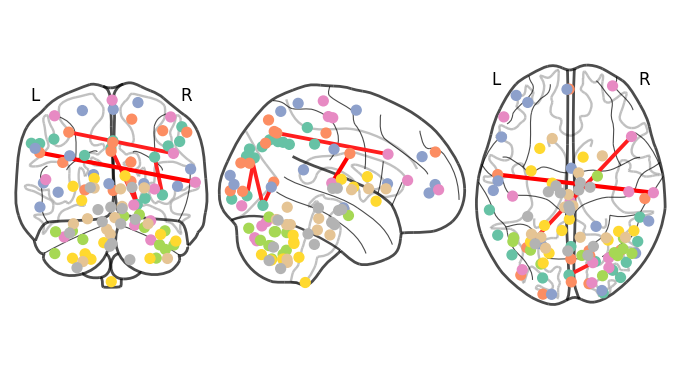

In [45]:
# plot it on the brain (averaging over all subjects)
plotting.plot_connectome(corr, atlas_coords, edge_threshold="99.9%")

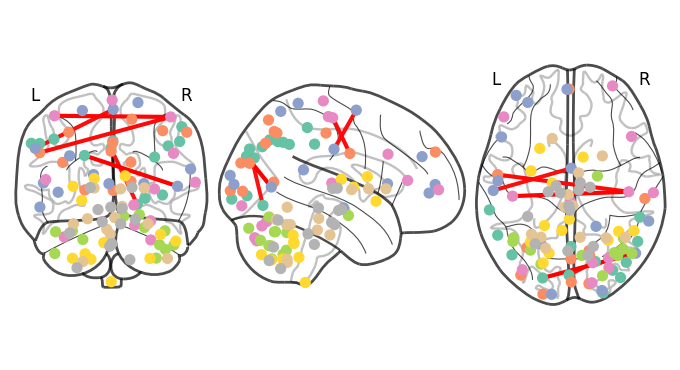

In [46]:
# plot it on the brain on one subject!!!
plotting.plot_connectome(corr1, atlas_coords, edge_threshold="99.9%")

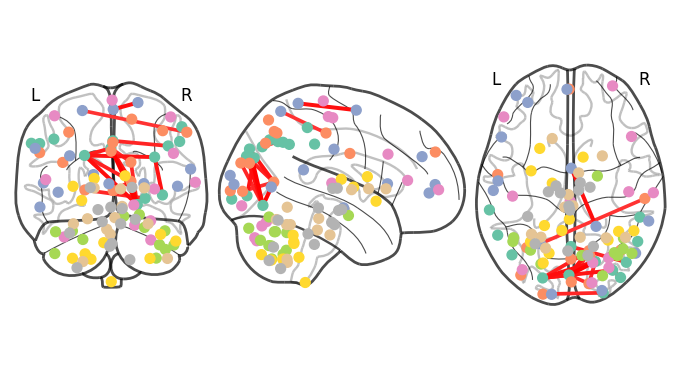

In [27]:
# If it is a string it must finish with a percent sign, e.g. “25.3%”, 
# and only the edges with a abs(value) above the given percentile will be shown.
plotting.plot_connectome(combined_covariance, atlas_coords, edge_threshold="99.7%")

In [89]:
#find the percentile regions
perc = np.percentile(abs(combined_covariance.flatten()), 98.7)

In [91]:
truth = combined_covariance >= perc
index = np.where(truth == True)
np.where(index[0] != index[1])

(array([ 1,  4,  6,  7,  8,  9, 12, 14, 16, 18, 20, 22, 23, 24, 26, 27, 28,
        30, 33, 34, 36, 37, 38, 40, 42, 48, 50, 54, 61, 66]),)

In [92]:
coord = [(index[0][i], index[1][i]) for i in np.where(index[0] != index[1])]
high_cor_pairings = np.stack(coord[0], axis=1)

In [93]:
unique_regions = list(set(high_cor_pairings.flatten()))
high_cor_coords = list(map(lambda x: x[1], filter(lambda x: x[0] in unique_regions, enumerate(atlas_coords))))

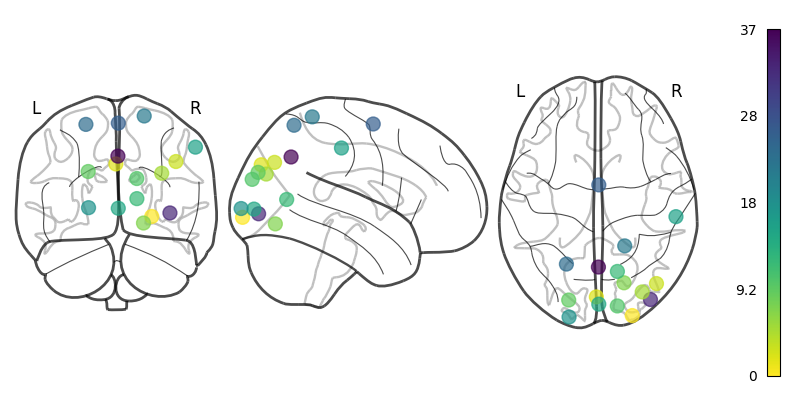

In [104]:
fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
plotting.plot_markers(node_values=unique_regions, node_coords=high_cor_coords, axes=axs)

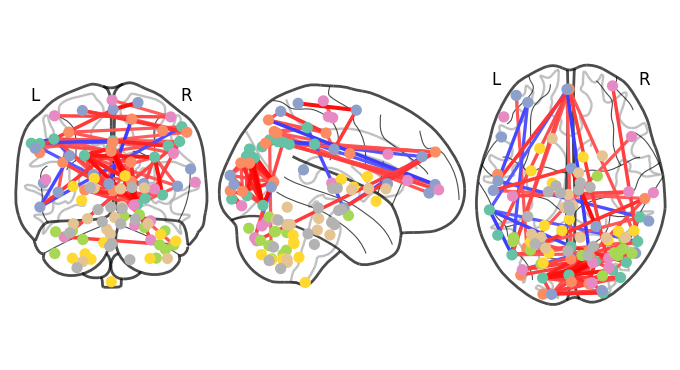

In [95]:
# If it is a string it must finish with a percent sign, e.g. “25.3%”, 
# and only the edges with a abs(value) above the given percentile will be shown.
plotting.plot_connectome(combined_covariance, atlas_coords, edge_threshold="98.7%")

In [ ]:
#it kind of looks like the edges don't match up... with my own percentile analysis... not sure why?

### Part 3: Try sliding window averaging covariance matrix

In [6]:
data.shape

(4800, 100)

In [7]:
len_5_min = 4800/4/3

In [11]:
def sliding_windows(data, num_windows, create_figure=False):
    len_window = 4800//num_windows
    window_matrices = []
    if create_figure:
        fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
    for i in range(num_windows):
        row = i//4
        col = i % 4
        i = int(i*len_window//2)
        lil_data = data[i: i + len_window]
        sub_corr_matrix = np.corrcoef(lil_data.T)
        window_matrices.append(sub_corr_matrix) 
        if create_figure:
            img = axs[row][col].imshow(sub_corr_matrix, cmap="RdBu_r",vmin=-1, vmax=1, interpolation="none")
        # axs[row][col].title(f"corr graph in window {i} to {i+len_5_min}")
        #plt.show()
    if create_figure:
        fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)
    return window_matrices

In [12]:
# Result Interpretation: A Jaccard Index close to 1 indicates high similarity, while a value closer to 0 indicates dissimilarity.
def jaccard_index(matrix1, matrix2, threshold=0.64):
    # Binarize matrices based on a threshold
    binary_matrix1 = (np.abs(matrix1) > threshold).astype(int)
    binary_matrix2 = (np.abs(matrix2) > threshold).astype(int)
    
    # Calculate intersection and union
    intersection = np.logical_and(binary_matrix1, binary_matrix2).sum()
    union = np.logical_or(binary_matrix1, binary_matrix2).sum()
    
    # Handle case where union is zero (avoid division by zero)
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    # Calculate Jaccard Index
    return intersection / union

def compute_scores(window_matrices, threshold=0.64):
    return {(i, i+1) :jaccard_index(window_matrices[i], window_matrices[i+1], threshold=threshold) for i in range(len(window_matrices)-1)}
# jaccard_score = jaccard_index(window_matrices[0], window_matrices[1], 0.64)
# print("Jaccard Index:", jaccard_score)

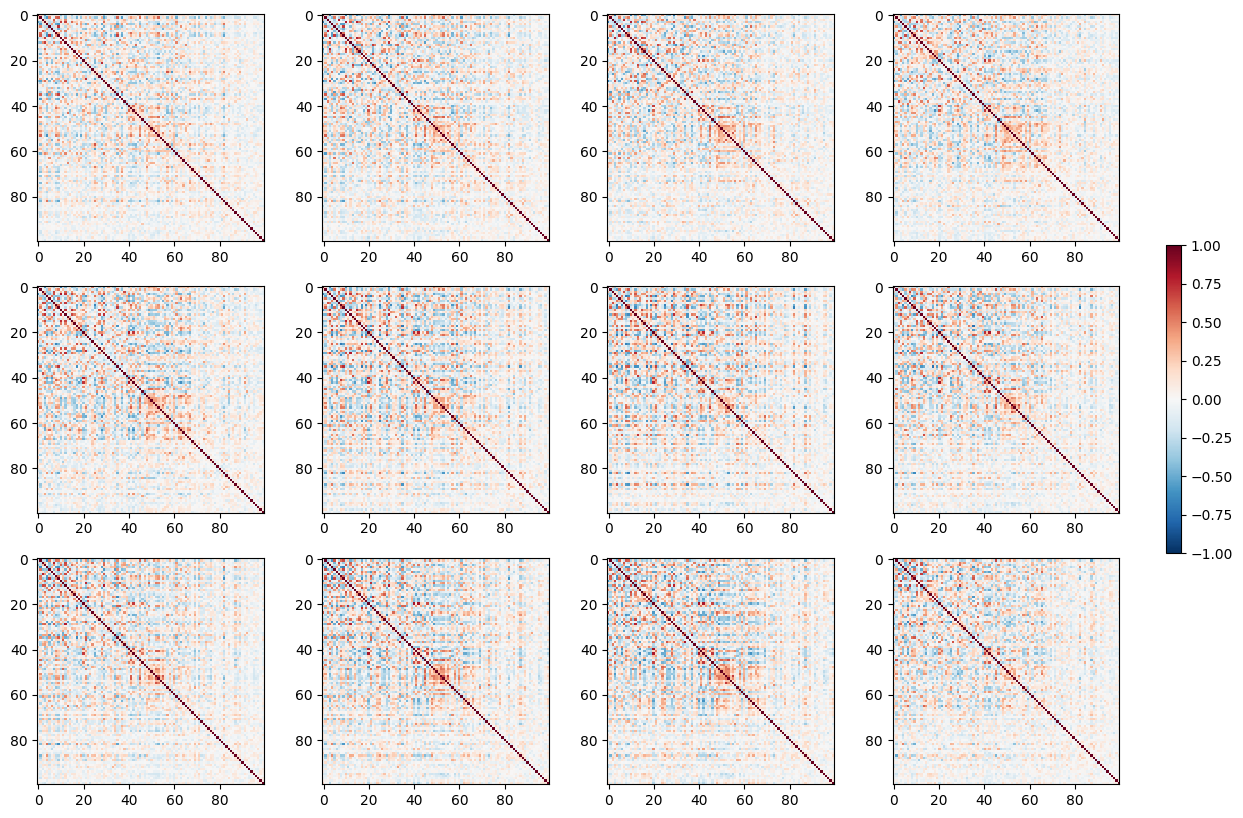

In [17]:
num_windows = 12
windows12 = sliding_windows(data, num_windows, True)

In [14]:
compute_scores(windows12)

{(0, 1): np.float64(0.7794117647058824),
 (1, 2): np.float64(0.9253731343283582),
 (2, 3): np.float64(0.782608695652174),
 (3, 4): np.float64(0.7808219178082192),
 (4, 5): np.float64(0.7325581395348837),
 (5, 6): np.float64(0.7340425531914894),
 (6, 7): np.float64(0.6703296703296703),
 (7, 8): np.float64(0.7162162162162162),
 (8, 9): np.float64(0.8055555555555556),
 (9, 10): np.float64(0.7848101265822784),
 (10, 11): np.float64(0.717948717948718)}

In [15]:
np.mean(list(compute_scores(windows12).values()))

np.float64(0.7663342265321312)

In [16]:
num_windows = 48
windows48 = sliding_windows(data, num_windows)

In [204]:
compute_scores(windows48)

[((0, 1), np.float64(0.7910447761194029)),
 ((1, 2), np.float64(0.726027397260274)),
 ((2, 3), np.float64(0.6547619047619048)),
 ((3, 4), np.float64(0.6421052631578947)),
 ((4, 5), np.float64(0.59)),
 ((5, 6), np.float64(0.6111111111111112)),
 ((6, 7), np.float64(0.5)),
 ((7, 8), np.float64(0.5619047619047619)),
 ((8, 9), np.float64(0.6601941747572816)),
 ((9, 10), np.float64(0.53125)),
 ((10, 11), np.float64(0.6066666666666667)),
 ((11, 12), np.float64(0.46258503401360546)),
 ((12, 13), np.float64(0.5979381443298969)),
 ((13, 14), np.float64(0.75)),
 ((14, 15), np.float64(0.7037037037037037)),
 ((15, 16), np.float64(0.7317073170731707)),
 ((16, 17), np.float64(0.6170212765957447)),
 ((17, 18), np.float64(0.5609756097560976)),
 ((18, 19), np.float64(0.4696969696969697)),
 ((19, 20), np.float64(0.4507042253521127)),
 ((20, 21), np.float64(0.5625)),
 ((21, 22), np.float64(0.5168539325842697)),
 ((22, 23), np.float64(0.4975124378109453)),
 ((23, 24), np.float64(0.44559585492227977)),
 ((2

In [220]:
np.mean(list(compute_scores(windows48).values()))

np.float64(0.5710870481004642)

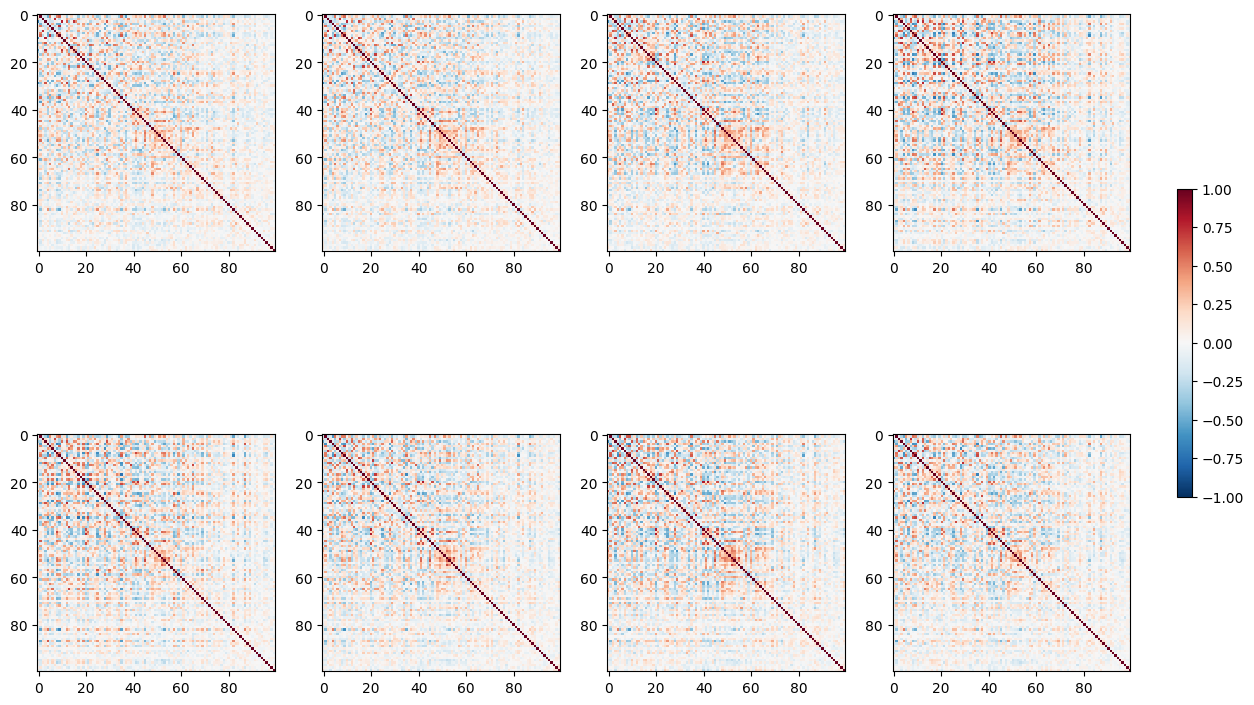

In [206]:
num_windows = 8
windows4 = sliding_windows(data, num_windows)

In [207]:
compute_scores(windows4)

[((0, 1), np.float64(0.9193548387096774)),
 ((1, 2), np.float64(0.8059701492537313)),
 ((2, 3), np.float64(0.7692307692307693)),
 ((3, 4), np.float64(0.7777777777777778)),
 ((4, 5), np.float64(0.7567567567567568)),
 ((5, 6), np.float64(0.8714285714285714)),
 ((6, 7), np.float64(0.7671232876712328))]

In [222]:
np.mean(list(compute_scores(windows4).values()))

np.float64(0.8096631644040738)

## Sliding Windows but make it regularized?

##### Applying Graphical LASSO on the whole data of one subject

In [6]:
#Computing windows but with graphical lasso:

import numpy as np
from sklearn.covariance import GraphicalLasso

# Generate synthetic data for demonstration
np.random.seed(42)
# n_samples, n_features = 100, 20
X = data

# Set the regularization parameter for L1 penalty (alpha)
alpha = 0.1  # Adjust this parameter for more or less sparsity

# Initialize and fit the GraphicalLasso model
model = GraphicalLasso(alpha=alpha, max_iter=10000, assume_centered=False)
model.fit(X)

# Retrieve the estimated precision matrix
precision_matrix = model.precision_

# Display the precision matrix
print("Estimated Precision Matrix:")
print(precision_matrix)

# Display the covariance matrix for completeness
covariance_matrix = model.covariance_
print("\nEstimated Covariance Matrix:")
print(covariance_matrix)


Estimated Precision Matrix:
[[ 6.15589928e-04  7.93375937e-05 -1.77123118e-04 ...  1.18850280e-05
   1.24010613e-06 -4.22063744e-06]
 [ 7.93375937e-05  1.24622842e-03 -2.52323751e-04 ...  2.40533879e-05
   4.18591668e-06  1.49632696e-06]
 [-1.77123118e-04 -2.52323751e-04  1.49041551e-03 ...  4.28011221e-06
  -3.29781668e-06  5.66240558e-07]
 ...
 [ 1.18850280e-05  2.40533879e-05  4.28011221e-06 ...  1.90809371e-04
  -1.51466609e-06 -1.05726289e-05]
 [ 1.24010613e-06  4.18591668e-06 -3.29781668e-06 ... -1.51466609e-06
   8.78216214e-05 -1.74235715e-07]
 [-4.22063744e-06  1.49632696e-06  5.66240558e-07 ... -1.05726289e-05
  -1.74235715e-07  9.52991484e-05]]

Estimated Covariance Matrix:
[[ 5.54656981e+03  4.68347738e+02  6.36555535e+02 ... -2.76964813e+02
   7.47744999e+02  1.06432473e+03]
 [ 4.68347738e+02  3.85660790e+03 -3.45171064e+02 ... -3.40187656e+02
   2.73757618e+02 -2.96681455e+01]
 [ 6.36555535e+02 -3.45171064e+02  2.94204282e+03 ... -2.43909138e+02
  -7.84827969e+01  1.00840

In [66]:
import numpy as np
from sklearn.covariance import GraphicalLasso
from sklearn.model_selection import KFold
from scipy.linalg import logm

# Function to calculate log-likelihood of a covariance matrix given precision matrix
def log_likelihood(X, precision_matrix):
    n = X.shape[0]
    log_det = np.linalg.slogdet(precision_matrix)[1]  # log determinant
    trace_term = np.trace(X @ precision_matrix)       # trace term
    return -0.5 * (n * log_det - trace_term)

# Cross-validation function to select best lambda for each subject
def cross_val_graphical_lasso(X, lambda_values, n_splits=5):
    best_lambda = None
    best_score = -np.inf
    
    # K-Fold cross-validation setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Iterate over candidate lambda values
    for alpha in lambda_values:
        cv_score = 0
        
        # For each fold, split into train and validation sets
        # for train_index, val_index in kf.split(X):
        # X_train, X_val = X[train_index], X[val_index]
        
        # Fit GraphicalLasso on training set
        model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-2)
        model.fit(X)
        
        # Calculate empirical covariance matrix on validation set
        cov_val = np.cov(X, rowvar=False)
        
        # Compute log-likelihood for validation set
        score = log_likelihood(cov_val, model.precision_)
        cv_score += score
        
        # Average score over folds
        avg_score = cv_score / n_splits
        
        # Update best lambda if current alpha has a higher score
        if avg_score > best_score:
            best_score = avg_score
            best_lambda = alpha

    return best_lambda

# Example usage
X = data

# Range of lambda values to test
lambda_values = np.logspace(0.01, 100)  # Adjust as necessary

# Find optimal lambda for subject
best_lambda = cross_val_graphical_lasso(X, lambda_values)
print("Optimal lambda:", best_lambda)

# Fit the final model with the optimal lambda
model = GraphicalLasso(alpha=best_lambda)
model.fit(X)
precision_matrix = model.precision_

print("Estimated Precision Matrix with Optimal Lambda:")
print(precision_matrix)


/Users/anastasiyamarkova/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.500e-01
  warnings.warn(
/Users/anastasiyamarkova/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.647e+01
  warnings.warn(
/Users/anastasiyamarkova/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.809e+03
  warnings.warn(
/Users/anastasiyamarkova/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.986e+05
  warnings.warn(
/Users/anastasiyamarkova/anaconda3/envs/capstone/lib/python3.12/site-pac

Optimal lambda: 12337.423983400502
Estimated Precision Matrix with Optimal Lambda:
[[ 1.80291610e-04 -0.00000000e+00 -0.00000000e+00 ...  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00  2.59295222e-04  0.00000000e+00 ...  0.00000000e+00
  -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00  3.39899879e-04 ...  0.00000000e+00
   0.00000000e+00 -0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.62103365e-04
  -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
   7.89343088e-05 -0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00  8.36221348e-05]]


/Users/anastasiyamarkova/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.939e+82
  warnings.warn(


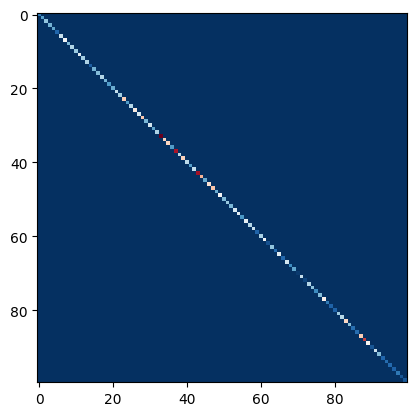

In [59]:
plt.imshow(precision_matrix, cmap="RdBu_r", interpolation="none")

In [60]:
def sliding_windows_LASSOed(data, num_windows):
    len_window = 4800//num_windows
    window_matrices = []
    fig, axs = plt.subplots(num_windows//4, 4, figsize=(15, 10))
    for i in range(num_windows):
        row = i//4
        col = i % 4
        i = int(i*len_window//2)
        lil_data = data[i: i + len_window]
        X = lil_data
        alpha = 4743.757162580401 # based on the previous example
        model = GraphicalLasso(alpha=alpha, max_iter=1000)
        model.fit(X)
        # Retrieve the estimated precision matrix
        precision_matrix = model.precision_
        window_matrices.append(precision_matrix) 
        if num_windows <= 4:
            img = axs[col].imshow(precision_matrix, cmap="RdBu_r", interpolation="none")
        else:
            img = axs[row][col].imshow(precision_matrix, cmap="RdBu_r", interpolation="none")
        # axs[row][col].title(f"corr graph in window {i} to {i+len_5_min}")
        #plt.show()
    fig.colorbar(img, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, shrink = 0.4)
    return window_matrices

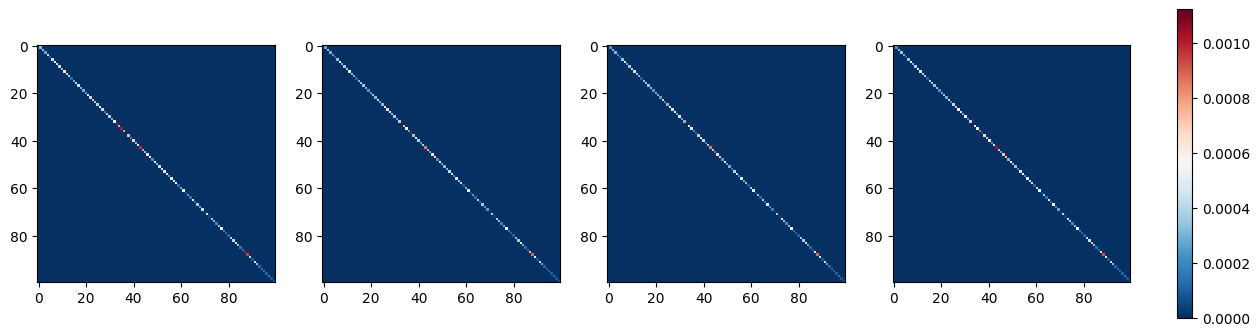

In [61]:
matrices = sliding_windows_LASSOed(data, 4)

In [62]:
matrices[0]

array([[ 1.77929760e-04, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  3.01230829e-04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  2.92128484e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.48128445e-04, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -0.00000000e+00,  7.83193837e-05, -0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00,  8.41815495e-05]])

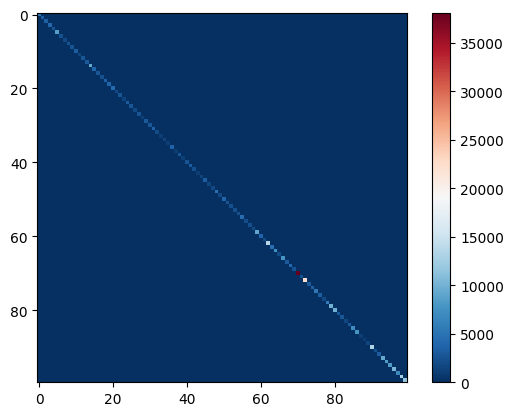

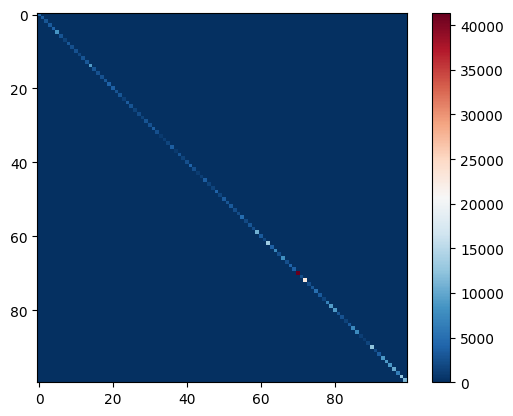

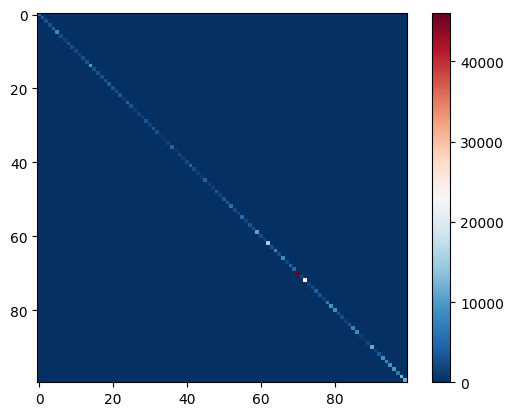

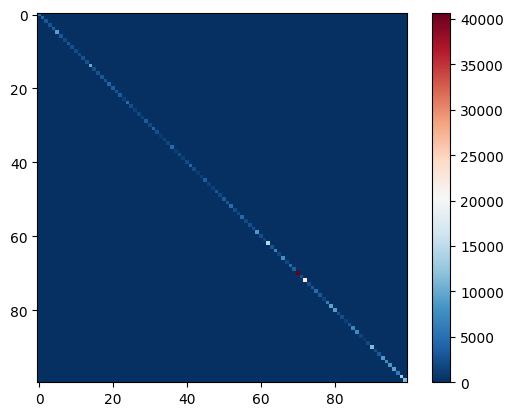

In [63]:
#trying to convert back to covariance matrices
cov = []
for m in matrices:
    cov_m = np.linalg.inv(m)
    plt.imshow(cov_m, cmap="RdBu_r", interpolation="none")
    plt.colorbar()
    plt.show()
    cov.append(cov_m)

In [64]:
cov

[array([[ 5620.19529539,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,  3319.71333472,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,  3423.1513066 , ...,
             0.        ,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
          6750.89784039,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        , 12768.23121089,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        , 11879.08758451]]),
 array([[ 4608.2873077 ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,  3443.40352556,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        , 

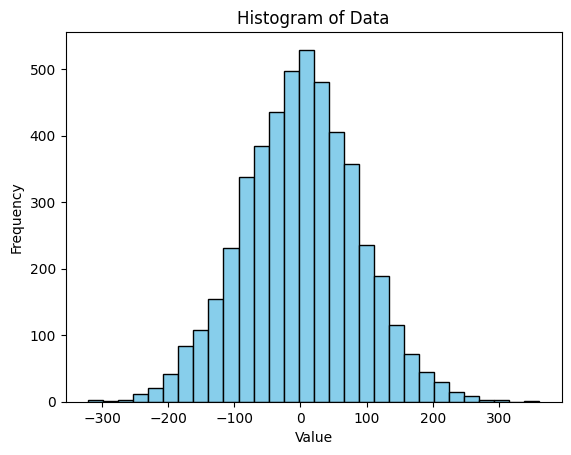

In [93]:
plt.hist((data[:, 86]), bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

In [77]:
from scipy.stats import shapiro

In [90]:
# Perform the Shapiro-Wilk test
not_normal = []
for i in range(100):
    statistic, p_value = shapiro(data[:, i])
    
    alpha = 0.05
    if p_value > alpha:
        pass
        # print(f"Data {i} looks normally distributed (fail to reject H0)")
    else:
        not_normal.append(i)
        # print(f"Data {i} does not look normally distributed (reject H0)")


In [91]:
len(not_normal)

55

In [94]:
 np.array(not_normal)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 38, 39, 42, 43, 44, 45, 46, 48, 50, 52, 53, 55, 59, 60, 63, 67,
       73, 76, 83, 87])

#### Clustering

In [20]:
windows12

[array([[ 1.        ,  0.26242389,  0.16626337, ..., -0.07222479,
          0.02717845,  0.08225056],
        [ 0.26242389,  1.        , -0.05495081, ..., -0.09476974,
         -0.03503266, -0.02327309],
        [ 0.16626337, -0.05495081,  1.        , ..., -0.1375334 ,
         -0.06966697, -0.06008175],
        ...,
        [-0.07222479, -0.09476974, -0.1375334 , ...,  1.        ,
          0.06067385,  0.00852247],
        [ 0.02717845, -0.03503266, -0.06966697, ...,  0.06067385,
          1.        ,  0.01016916],
        [ 0.08225056, -0.02327309, -0.06008175, ...,  0.00852247,
          0.01016916,  1.        ]]),
 array([[ 1.        ,  0.12596952,  0.30560791, ...,  0.02452413,
          0.10321713,  0.03693102],
        [ 0.12596952,  1.        , -0.22273444, ..., -0.10864418,
         -0.01576543, -0.01706105],
        [ 0.30560791, -0.22273444,  1.        , ..., -0.03926434,
          0.03068086,  0.02461845],
        ...,
        [ 0.02452413, -0.10864418, -0.03926434, ...,  

Cluster 1: Matrices [5, 6, 7]
Cluster 2: Matrices [8, 11]
Cluster 3: Matrices [0, 3, 4]
Cluster 4: Matrices [9, 10]
Cluster 5: Matrices [1, 2]


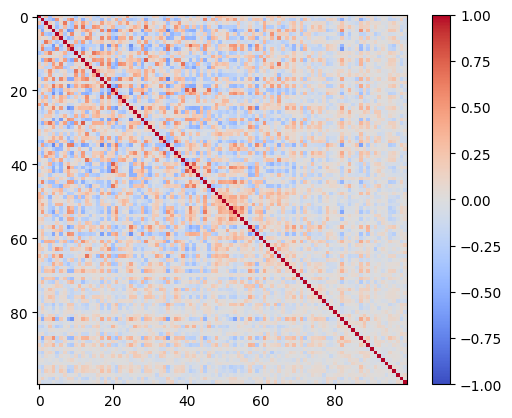

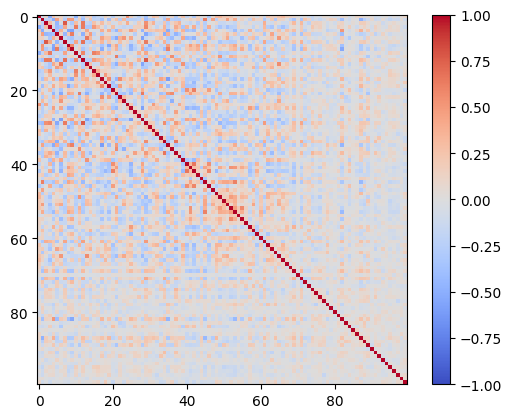

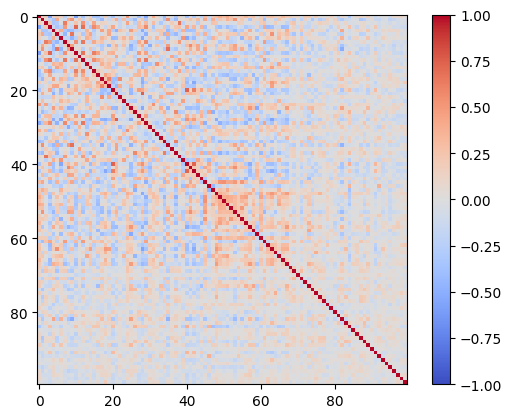

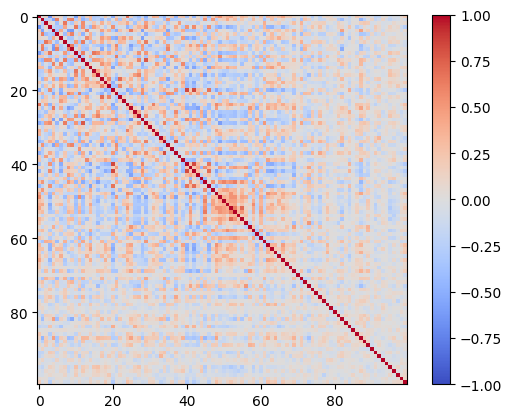

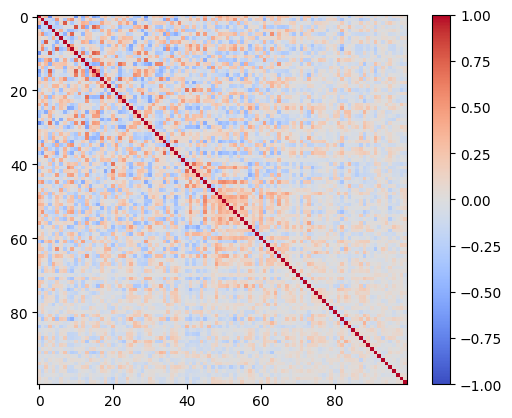

Centroid Matrices: [array([[ 1.        , -0.04709864,  0.26874275, ..., -0.00484229,
         0.00496336,  0.08691759],
       [-0.04709864,  1.        , -0.23315019, ..., -0.07861707,
         0.14709098, -0.11687219],
       [ 0.26874275, -0.23315019,  1.        , ...,  0.0169262 ,
        -0.04578208, -0.08101378],
       ...,
       [-0.00484229, -0.07861707,  0.0169262 , ...,  1.        ,
         0.03015974,  0.10379471],
       [ 0.00496336,  0.14709098, -0.04578208, ...,  0.03015974,
         1.        ,  0.03800881],
       [ 0.08691759, -0.11687219, -0.08101378, ...,  0.10379471,
         0.03800881,  1.        ]]), array([[ 1.        , -0.10005064,  0.09182914, ..., -0.04192183,
         0.02900068,  0.09627151],
       [-0.10005064,  1.        , -0.20453029, ..., -0.12452246,
         0.04194703, -0.09309113],
       [ 0.09182914, -0.20453029,  1.        , ...,  0.02324988,
        -0.01714928, -0.01576193],
       ...,
       [-0.04192183, -0.12452246,  0.02324988, ...,  1

In [27]:
#Kmediods
import numpy as np

def vectorize_matrix(matrix):
    # Use the upper triangular part, excluding the diagonal
    return matrix[np.triu_indices_from(matrix, k=1)]

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def assign_clusters(data, centroids):
    clusters = [[] for _ in centroids]
    for idx, point in enumerate(data):
        # Calculate Manhattan distance to each centroid
        distances = [manhattan_distance(point, centroid) for centroid in centroids]
        # Assign point to the nearest centroid
        closest_centroid = np.argmin(distances)
        clusters[closest_centroid].append(idx)
    return clusters

def update_centroids(data, clusters):
    new_centroids = []
    for cluster in clusters:
        # Calculate the new centroid by taking the median of points in the cluster
        if cluster:  # Ensure the cluster is not empty
            cluster_points = np.array([data[i] for i in cluster])
            new_centroid = np.median(cluster_points, axis=0)
            new_centroids.append(new_centroid)
        else:
            # Handle empty clusters by randomly reassigning to an existing point
            new_centroids.append(data[np.random.randint(0, data.shape[0])])
    return np.array(new_centroids)

def kmeans_manhattan_covariance(matrices, k, max_iters=100, tol=1e-4):
    # Step 1: Vectorize each covariance matrix
    data = np.array([vectorize_matrix(mat) for mat in matrices])

    # Step 2: Randomly initialize centroids from the vectorized data
    initial_centroid_indices = np.random.choice(range(len(data)), k, replace=False)
    centroids = data[initial_centroid_indices]
    
    for iteration in range(max_iters):
        # Assignment step: assign points to the nearest centroid
        clusters = assign_clusters(data, centroids)
        
        # Update step: calculate new centroids based on median
        new_centroids = update_centroids(data, clusters)
        
        # Check for convergence (centroids change less than tolerance)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        
        centroids = new_centroids
    
    # Generate final cluster labels
    for cluster_idx, cluster in enumerate(clusters):
        print(f"Cluster {cluster_idx + 1}: Matrices {cluster}")
    
    return clusters, centroids

# Example usage
np.random.seed(0)

# Generate example covariance matrices (replace with actual covariance matrices)
matrices = windows12  
k = 5  # Number of clusters

clusters, centroids = kmeans_manhattan_covariance(matrices, k)

# Convert centroids back to square matrix form for interpretation
n_features = matrices[0].shape[0]
centroid_matrices = []
for vector in centroids:
    centroid_matrix = np.zeros((n_features, n_features))
    centroid_matrix[np.triu_indices_from(centroid_matrix, k=1)] = vector
    centroid_matrix += centroid_matrix.T  # Make symmetric
    np.fill_diagonal(centroid_matrix, 1)  # Diagonal entries as 1 (assuming standardized covariances)
    centroid_matrices.append(centroid_matrix)
    plt.imshow(centroid_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    # plt.title(f"Cluster {i + 1} Mean Correlation Pattern")
    plt.show()

print("Centroid Matrices:", centroid_matrices)



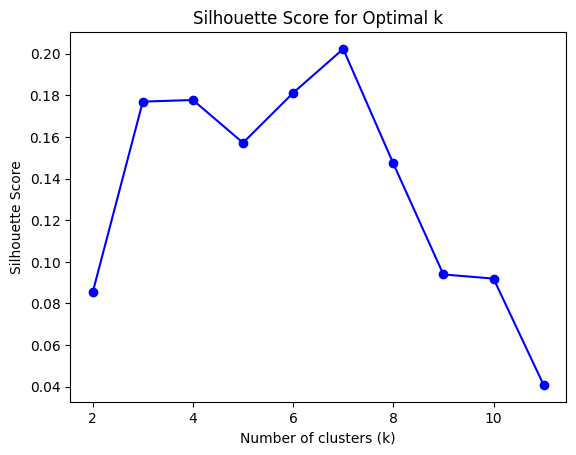

Cluster 1:
 - Matrix 6
 - Matrix 7
Cluster 2:
 - Matrix 4
 - Matrix 5
Cluster 3:
 - Matrix 10
 - Matrix 11
Cluster 4:
 - Matrix 2
 - Matrix 3
Cluster 5:
 - Matrix 12
Cluster 6:
 - Matrix 1
Cluster 7:
 - Matrix 8
 - Matrix 9


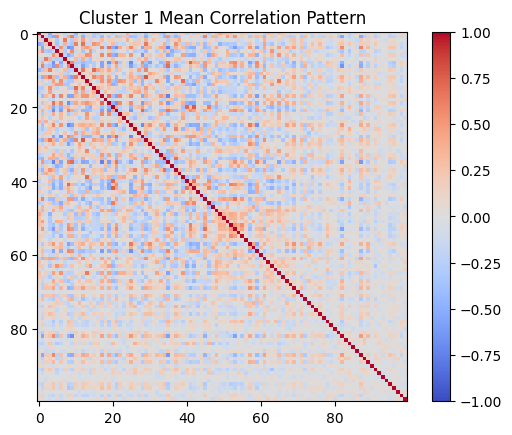

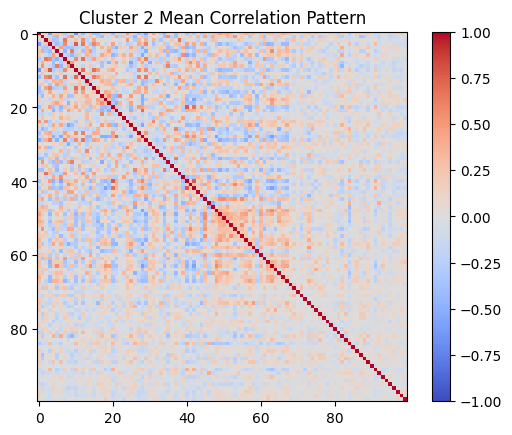

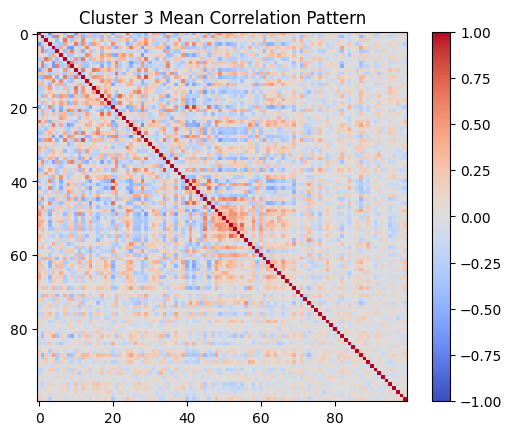

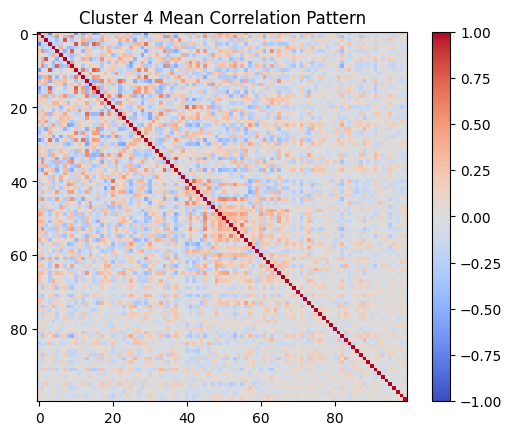

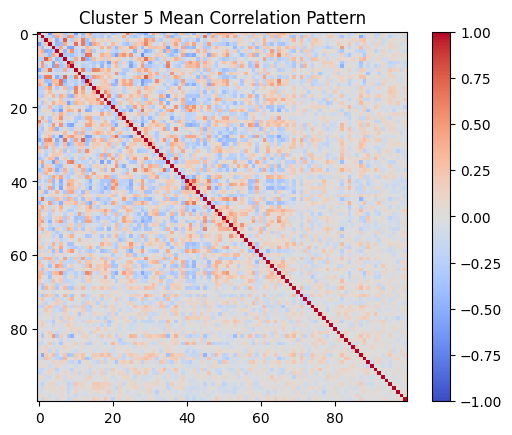

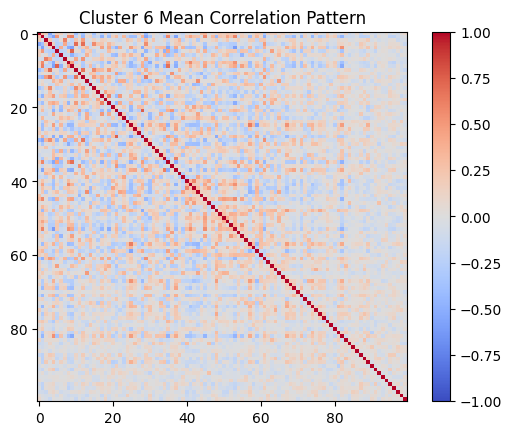

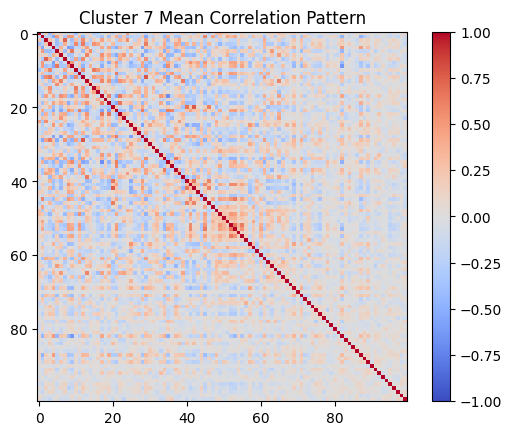

In [30]:
#KMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Example data: list of correlation matrices (replace with your actual data)
correlation_matrices = windows12

# Step 1: Vectorize the correlation matrices
# We'll use the upper triangular part, excluding the diagonal
def vectorize_corr_matrix(matrix):
    # Extract the upper triangular part, excluding the diagonal
    return matrix[np.triu_indices_from(matrix, k=1)]

# Apply the vectorization to each correlation matrix
vectorized_matrices = np.array([vectorize_corr_matrix(mat) for mat in correlation_matrices])

# Step 2: Run k-means clustering
# Determine the best number of clusters (k) using silhouette score or elbow method
silhouette_scores = []
K = range(2, 12)  # Try different values for k

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(vectorized_matrices)
    silhouette_scores.append(silhouette_score(vectorized_matrices, labels))

# Plot silhouette scores to choose k
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

# After determining the best k, fit the final model
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(vectorized_matrices)

# Step 3: Analyze the clusters
# Print each cluster's label and corresponding matrices
for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    print(f"Cluster {i + 1}:")
    for idx in cluster_indices:
        print(f" - Matrix {idx + 1}")

# Optional: Visualize cluster centers (mean correlation patterns per cluster)
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    # Reshape back to triangular matrix form (for visualization)
    mean_corr_matrix = np.zeros((100, 100))
    mean_corr_matrix[np.triu_indices_from(mean_corr_matrix, k=1)] = center
    mean_corr_matrix += mean_corr_matrix.T  # Make it symmetric
    np.fill_diagonal(mean_corr_matrix, 1)

    plt.imshow(mean_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f"Cluster {i + 1} Mean Correlation Pattern")
    plt.show()


In [18]:
cor_matrices = []
for i in sub_data[:500]:
    sliding_windows(i, 12)
    cor_matrices += sliding_windows(i, 12)

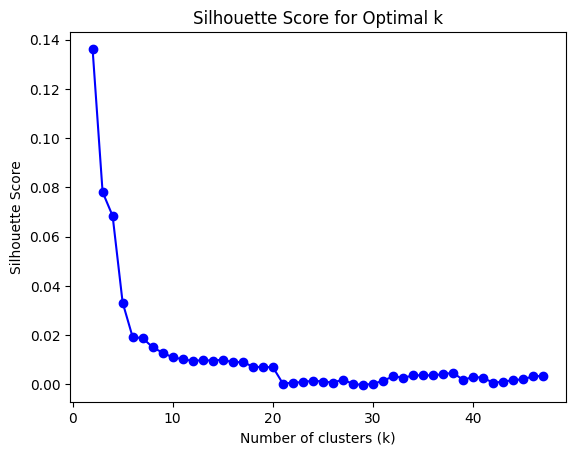

Cluster 1:
 - Matrix 1
 - Matrix 2
 - Matrix 3
 - Matrix 4
 - Matrix 5
 - Matrix 6
 - Matrix 7
 - Matrix 8
 - Matrix 9
 - Matrix 10
 - Matrix 11
 - Matrix 12
 - Matrix 13
 - Matrix 14
 - Matrix 15
 - Matrix 16
 - Matrix 17
 - Matrix 18
 - Matrix 19
 - Matrix 20
 - Matrix 21
 - Matrix 22
 - Matrix 23
 - Matrix 24
 - Matrix 25
 - Matrix 26
 - Matrix 27
 - Matrix 28
 - Matrix 29
 - Matrix 30
 - Matrix 31
 - Matrix 32
 - Matrix 33
 - Matrix 34
 - Matrix 35
 - Matrix 36
 - Matrix 43
 - Matrix 44
 - Matrix 48
 - Matrix 49
 - Matrix 50
 - Matrix 51
 - Matrix 52
 - Matrix 53
 - Matrix 54
 - Matrix 55
 - Matrix 56
 - Matrix 57
 - Matrix 58
 - Matrix 59
 - Matrix 60
 - Matrix 61
 - Matrix 62
 - Matrix 63
 - Matrix 64
 - Matrix 67
 - Matrix 68
 - Matrix 69
 - Matrix 70
 - Matrix 71
 - Matrix 72
 - Matrix 73
 - Matrix 74
 - Matrix 75
 - Matrix 76
 - Matrix 77
 - Matrix 78
 - Matrix 79
 - Matrix 80
 - Matrix 81
 - Matrix 82
 - Matrix 83
 - Matrix 84
 - Matrix 85
 - Matrix 86
 - Matrix 87
 - Matrix 

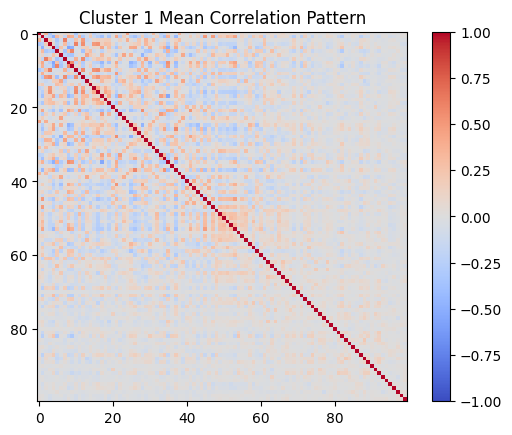

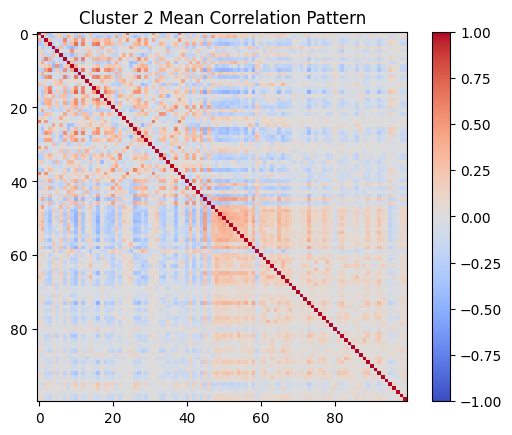

In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Example data: list of correlation matrices (replace with your actual data)
correlation_matrices = sub_data

# Step 1: Vectorize the correlation matrices
# We'll use the upper triangular part, excluding the diagonal
def vectorize_corr_matrix(matrix):
    # Extract the upper triangular part, excluding the diagonal
    return matrix[np.triu_indices_from(matrix, k=1)]

# Apply the vectorization to each correlation matrix
vectorized_matrices = np.array([vectorize_corr_matrix(mat) for mat in correlation_matrices])

# Step 2: Run k-means clustering
# Determine the best number of clusters (k) using silhouette score or elbow method
silhouette_scores = []
K = range(2, 48)  # Try different values for k

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(vectorized_matrices)
    silhouette_scores.append(silhouette_score(vectorized_matrices, labels))

# Plot silhouette scores to choose k
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

# After determining the best k, fit the final model
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(vectorized_matrices)

# Step 3: Analyze the clusters
# Print each cluster's label and corresponding matrices
for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    print(f"Cluster {i + 1}:")
    for idx in cluster_indices:
        print(f" - Matrix {idx + 1}")

# Optional: Visualize cluster centers (mean correlation patterns per cluster)
cluster_centers = kmeans.cluster_centers_
for i, center in enumerate(cluster_centers):
    # Reshape back to triangular matrix form (for visualization)
    mean_corr_matrix = np.zeros((100, 100))
    mean_corr_matrix[np.triu_indices_from(mean_corr_matrix, k=1)] = center
    mean_corr_matrix += mean_corr_matrix.T  # Make it symmetric
    np.fill_diagonal(mean_corr_matrix, 1)

    plt.imshow(mean_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f"Cluster {i + 1} Mean Correlation Pattern")
    plt.show()
